<a href="https://colab.research.google.com/github/hechoii/AI_Practice/blob/main/HUMAN_EMOTIONS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LƯU CHECKPOINT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn lưu file trên Drive của bạn
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/checkpoints/lenet_fashion_best.keras"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,       # Chỉ lưu phiên bản tốt nhất (val_loss thấp nhất)
    monitor='val_loss',        # Theo dõi giá trị loss trên tập validation
    mode='min',                # Lưu khi giá trị monitor đạt mức nhỏ nhất
    verbose=1                  # Hiện thông báo mỗi khi lưu thành công
)

In [3]:
from tensorflow.keras.models import load_model

# Tải lại toàn bộ cấu trúc và trọng số tốt nhất đã lưu
lenet_model = load_model("/content/drive/MyDrive/Colab Notebooks/checkpoints/lenet_fashion_best.keras")

# Bây giờ bạn có thể dùng nó để dự đoán (predict) ngay lập tức
print("Model đã được khôi phục thành công!")

Model đã được khôi phục thành công!


# THƯ VIỆN

In [5]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

# DOWLOAD DATA

In [6]:
! pip install -q kaggle

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 93% 288M/309M [00:00<00:00, 461MB/s]
100% 309M/309M [00:00<00:00, 414MB/s]


In [10]:
# Giải nén file đã có sẵn vào thư mục 'data_emotions'
!unzip -q /content/human-emotions-datasethes.zip -d /content/

# Kiểm tra xem các thư mục con (như Happy, Sad, Angry...) đã xuất hiện chưa
!ls /content/

 drive		     EmotionsDataset_Splitted	     sample_data
'Emotions Dataset'   human-emotions-datasethes.zip
 EmotionsDataset     kaggle.json


# CONFIGURE

In [11]:
train_directory = "/content/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/Emotions Dataset/Emotions Dataset/test"
CLASS_NAME = ["angry" , "happy" , "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IMG_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "N_UNITS_1": 1024,
    "N_UNITS_2": 128,
    "N_FILTERS": 6,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "KERNEL_SIZE": 3,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

# LOAD DATASET

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [13]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


# VISUALIZATION

In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

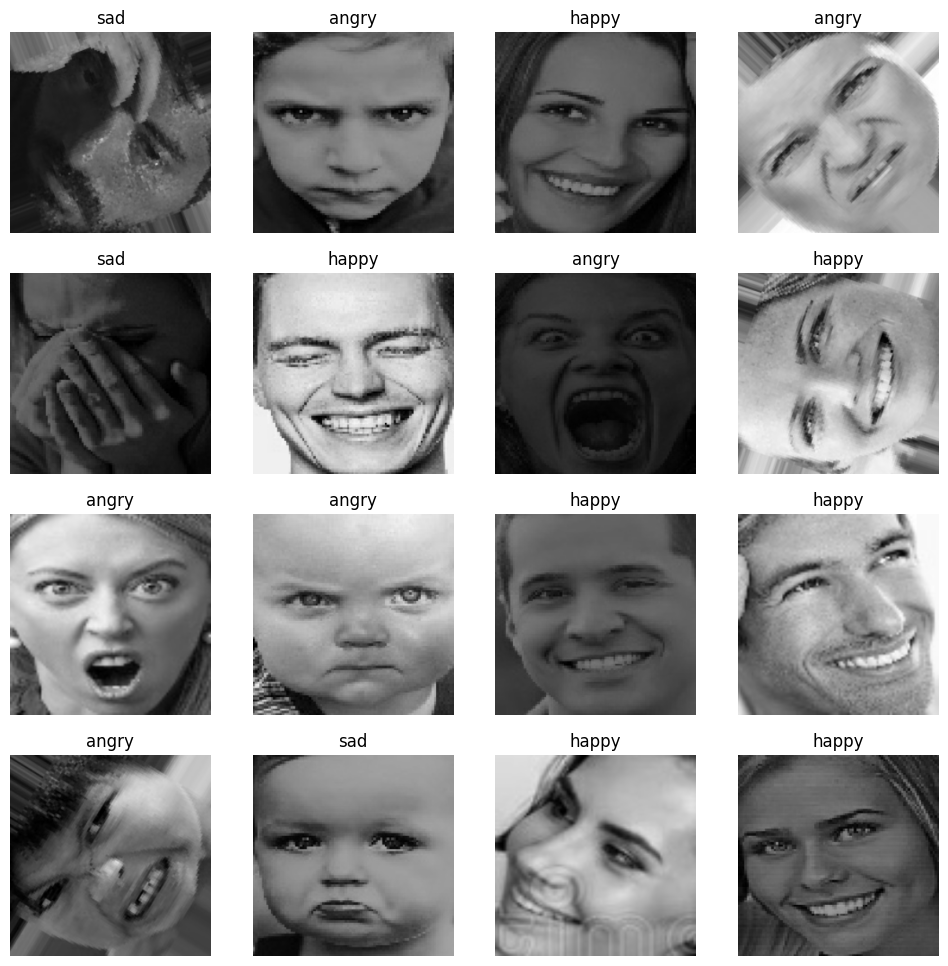

In [ ]:
plt.figure(figsize = (12,12) )
for image, label in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255.)
    plt.title( CLASS_NAME[tf.argmax(label[i], axis=0).numpy()] )
    plt.axis("off")

# DATA AUGMENTATION

In [14]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025,0.025),),
    RandomFlip("horizontal"),
    RandomContrast(factor=0.1),
])

In [15]:
def augment_layer(image, label):
    return augment_layers(image, training =True), label

## AUGMENTATION

In [16]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IMG_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IMG_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IMG_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IMG_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IMG_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IMG_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IMG_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IMG_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [17]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IMG_SIZE"]*CONFIGURATION["IMG_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

# PREPARATION

In [18]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [19]:
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# training_dataset = (
#     train_dataset
#     .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )


In [20]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [21]:
resize_scale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION['IMG_SIZE'],CONFIGURATION['IMG_SIZE']),
    Rescaling(1./255)
])

# MODEL

In [22]:
lenet_model = tf.keras.Sequential (
    [
        InputLayer(shape = ( None, None ,3 ) ),
        resize_scale_layer,

        Conv2D( filters = CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
               activation="relu", kernel_regularizer=L2( CONFIGURATION["REGULARIZATION_RATE"] ) ),
        BatchNormalization(),
        MaxPool2D( pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2 ),
        Dropout( rate = CONFIGURATION["DROPOUT_RATE"] ),

        Conv2D( filters = CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding="valid",
               activation="relu", kernel_regularizer=L2( CONFIGURATION["REGULARIZATION_RATE"] ) ),
        BatchNormalization(),
        MaxPool2D( pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2 ),

        Flatten(),

        Dense( CONFIGURATION["N_UNITS_1"], activation="relu", kernel_regularizer = L2( CONFIGURATION["REGULARIZATION_RATE"] ) ),
        BatchNormalization(),
        Dropout( rate = CONFIGURATION["DROPOUT_RATE"] ),

        Dense( CONFIGURATION["N_UNITS_2"], activation="relu", kernel_regularizer = L2( CONFIGURATION["REGULARIZATION_RATE"] ) ),
        BatchNormalization(),

        Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    ]
)

lenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    62,981,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

# TRAINING

In [23]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy(from_logits=False)

In [24]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.9, 0.05], [0.05, 0.05, 0.95]]

# dùng "auto"/"sum_over-batch_size" để giảm số lớp
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

0.102722004


In [25]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [26]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [35]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #callbacks=[checkpoint_callback],
)

Epoch 1/20
 75/213 ━━━━━━━━━━━━━━━━━━━━ 10:22 5s/step - accuracy: 0.4270 - loss: 1.4703 - top_k_accuracy: 0.7624

KeyboardInterrupt: 

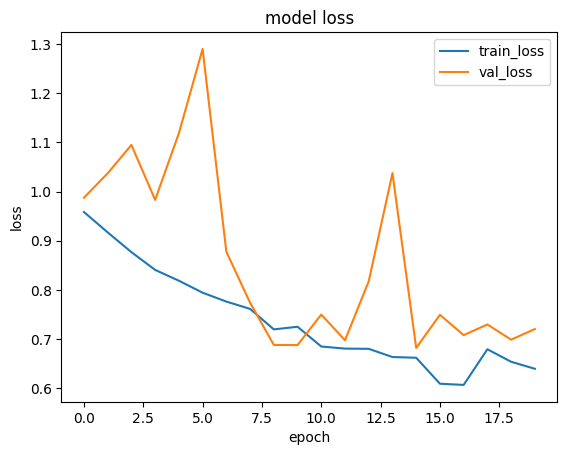

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

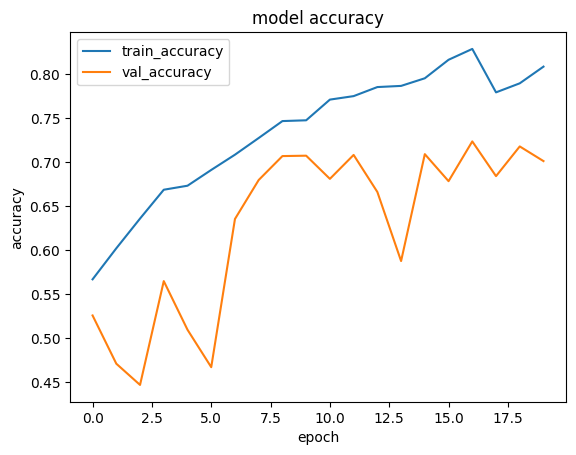

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# EVALUATION

In [27]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 61s 833ms/step - accuracy: 0.4254 - loss: 1.0919 - top_k_accuracy: 0.7651


[1.0918430089950562, 0.4135206341743469, 0.7730465531349182]

# Testing

In [28]:
test_image = cv2.imread("/content/Emotions Dataset/Emotions Dataset/test/happy/123763.jpg_brightness_1.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(lenet_model(im))
print(CLASS_NAME[tf.argmax(lenet_model(im), axis=1).numpy()[0]])

tf.Tensor([[0.31077313 0.37503707 0.31418976]], shape=(1, 3), dtype=float32)
happy


In [29]:
test_image = cv2.imread("/content/Emotions Dataset/Emotions Dataset/test/sad/108893.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(lenet_model(im))
print(CLASS_NAME[tf.argmax(lenet_model(im), axis=1).numpy()[0]])

tf.Tensor([[0.2823253  0.3722263  0.34544843]], shape=(1, 3), dtype=float32)
happy


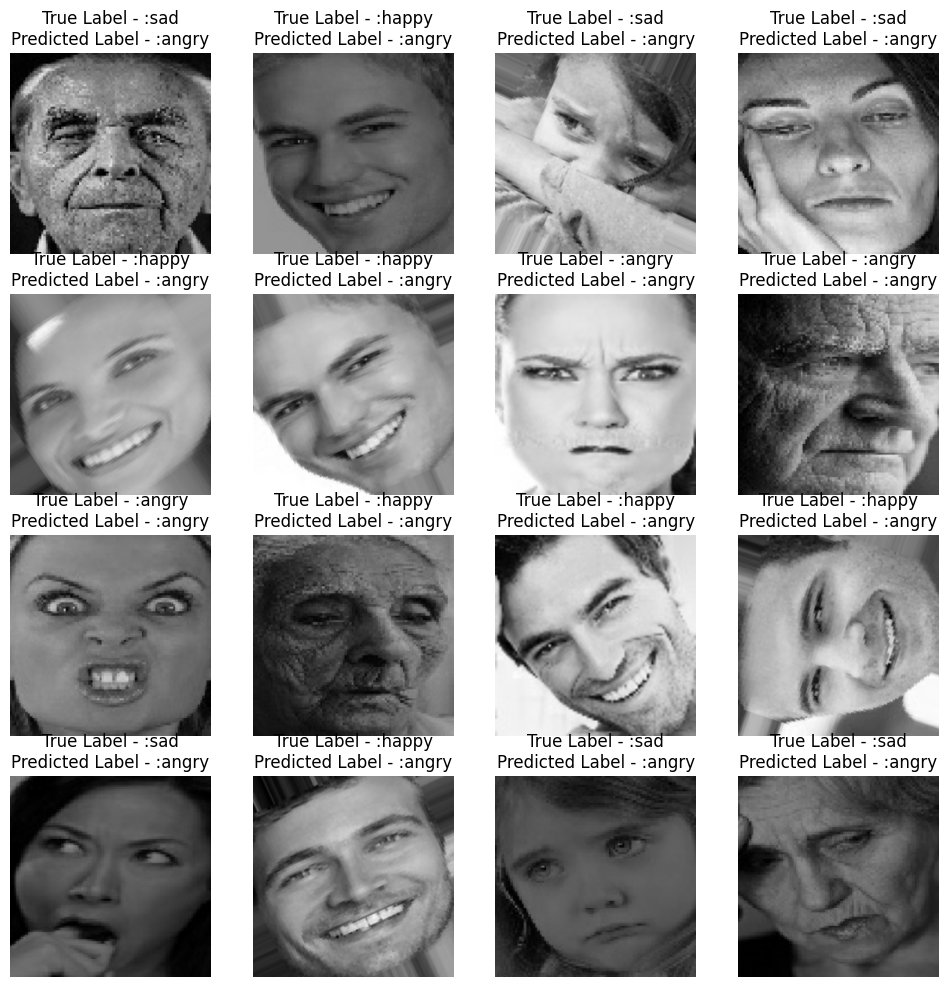

In [30]:
plt.figure(figsize = (12,12) )
for image, label in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255.)
    plt.title( "True Label - :"
              + CLASS_NAME[tf.argmax(label[i], axis=0).numpy()]
              + "\n" +"Predicted Label - :"
              + CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(image[i], axis = 0))).numpy()[0]] )
    plt.axis("off")

# Confusion Matrix

In [31]:
labels = []
predicted = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [32]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 2 ... 1 2 1]
[2 2 2 ... 2 1 2]


In [33]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[ 83 195 237]
 [123 347 536]
 [127 256 374]]


Text(0.5, 58.7222222222222, 'Predicted label')

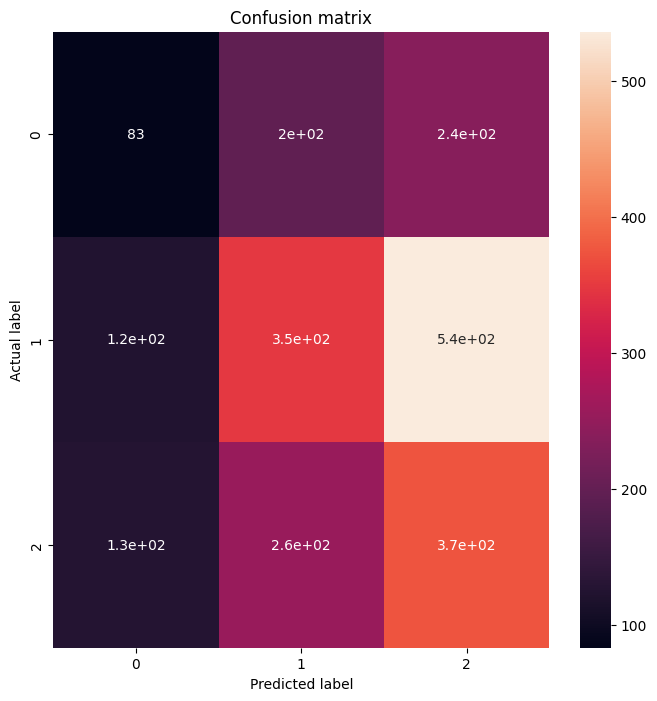

In [34]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# TFRECORDS

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
val_dataset = (
    validation_dataset
    .unbatch()
)

In [ ]:
train_dataset

In [ ]:
val_dataset

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list = BytesList(value = [image])
  )
  int64_feature = Feature(
      int64_list = Int64List(value = [label])
  )

  example = Example(
      features = Features(
          feaature = {
              'images': bytes_feature,
              'labels': int64_feature
          }
      )
  )

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)

  return image, argmax(label)


In [ ]:
encoded_dataset = (
    train_dataset
    .map(encode-image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )

In [ ]:
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# val_parsed_dataset = (
#     val_recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
parsed_dataset

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

In [ ]:
# val_parsed_dataset

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)


In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )